# **Brain Tumor Radiogenomic Classification** --> 3D CNN with PyTorch

### Outline  
1. [Problem Description](#description)    
2. [Modeling Approach](#approach)
3. [Exploring the data](#exploring)
4. [Model Architecture](#model)
5. [Training a Pytorch Estimator](#training)
6. [Deploying the Model](#deploy)
7. [Perform Inference](#predict)

<a id='description'></a>
### Problem Description<sup>[[1]](#1)</sup> 
A malignant tumor in the brain is a life-threatening condition. Known as glioblastoma, it's both the most common form of brain cancer in adults and the one with the worst prognosis, with median survival being less than a year. The presence of a specific genetic sequence in the tumor known as MGMT promoter methylation has been shown to be a favorable prognostic factor and a strong predictor of responsiveness to chemotherapy.

Currently, genetic analysis of cancer requires surgery to extract a tissue sample. Then it can take several weeks to determine the genetic characterization of the tumor. Depending upon the results and type of initial therapy chosen, a subsequent surgery may be necessary. If an accurate method to predict the genetics of the cancer through imaging (i.e., radiogenomics) alone could be developed, this would potentially minimize the number of surgeries and refine the type of therapy required.

This project will attempt to predict the genetic subtype of glioblastoma using MRI (magnetic resonance imaging) scans by training a model to detect for the presence of MGMT promoter methylation. This essentially is a binary classification problem. 

<a id='approach'></a>
### Modeling Approach
Due to the sequential nature of MRI images, the modeling appoach lends itself to using a 3D convolutional neural network. This approach will capture the 3D spatial data in the sequence. Another approach could be to look at this problem through the lense of a LSTM network however it is not necessary to capture, in memory, previous image sequences. We must look at the sequence of MRI images as parts of a full three dimensional reconstruction of the brain. This notebook will walk through the steps, using AWS Sagemaker, to build a custom PyTorch 3D CNN model for training and inference purposes. 

In [2]:
# !pip install pydicom

In [3]:
# necessary imports
import os
import sys
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# sagemaker specific imports
import boto3
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

sagemaker_bucket = sagemaker_session.default_bucket()
print(sagemaker_bucket)

<a id='exploring'></a>
### Exploring the Data

The data<sup>[[2]](#2)</sup>  is defined by three cohorts: _Training_, _Test (Validation)_, and _Testing_. The _Testing_ dataset is kept private and is used to test the competition submission entries. The _Test_ dataset, available for use, represents about 20% the size of the private _Testing_ dataset. Each top level folder represents a subject idicated by a five digit number. Within each of the folders are the four different MRI tests, FLAIR, T1w, T1wCE, and T2w. Each of these test folders has the respective imgages in DICOM format. The Tests and data structure are as follows:

1.  **FLAIR** - Fluid Attenuated Inversion Recovery
2.  **T1w** - T1-weighted pre-contrast
    * fluid (black) - low signal intensity
    * fat (white) - high signal intensity
    * grey matter (grey) - intermediate signal intensity
    * white matter (white-ish)
3.  **T1wCE** - T1-weighted post-contrast
4.  **T2w** - T2-weighted 
    * fluid (white) - high signal intensity
    * fat (white) - high signal intensity
    * grey matter (grey) - intermediate signal intensity
    * white matter (black-ish)
<p align="center">
<img width="900" src = "images/MRI Data Structure.png">
</p>

**NOTE:** There are some unexpected issues with the following three cases in the training dataset, participants can exclude the cases during training:   
[00109, 00123, 00709]

In [55]:
# project specific data paths
train_labels_key = 'train_labels.csv'

s3_prefix = 'Radiogenomic'
output_path = 's3://{}/{}/'.format(sagemaker_bucket, s3_prefix)
print('Model artifacts and data will be stored in ', output_path)

train_labels_df = pd.read_csv(os.path.join(output_path, train_labels_key))
print("Num train labels: ", len(train_labels_df))
train_labels_df.tail()

Model artifacts and data will be stored in  s3://sagemaker-us-west-2-904606187431/Radiogenomic/
Num train labels:  585


,BraTS21ID,MGMT_value
580,1005,1
581,1007,1
582,1008,1
583,1009,0
584,1010,0


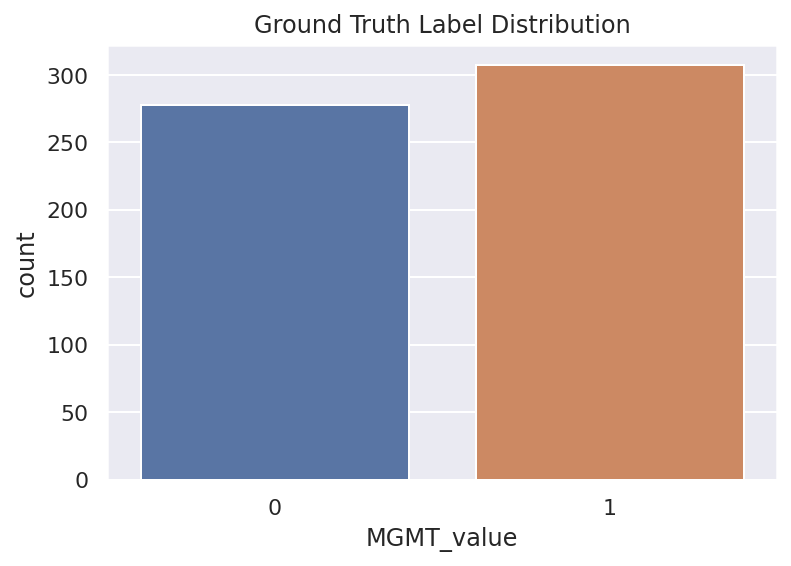

In [7]:
sns.countplot(data=train_labels_df, x='MGMT_value')
ax = sns.set_theme(style='darkgrid')
plt.title('Ground Truth Label Distribution')
plt.show()

#### Read DICOM Metadata
Read in DICOM image metadata and extract image pixel data.

In [56]:
import io

s3_prefix = "Radiogenomic"
data_prefix = 'data/train'
patient_num = '00000'
image_type = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
image_num = 'Image-222.dcm'

In [57]:
# reading from s3 bucket
s3_path = os.path.join(s3_prefix, 'train', patient_num, image_type[0], image_num)
print('s3 path: ', s3_path)
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=sagemaker_bucket, Key=s3_path)
s3_test_meta = pydicom.dcmread(io.BytesIO(obj['Body'].read()))

# reading from local sagemaker instance storage
path = os.path.join(data_prefix, patient_num, image_type[0], image_num)
print('Local path: ', path)
print()

test_meta = pydicom.dcmread(path)
print(test_meta)
print("\nSize of DICOM image:", test_meta.pixel_array.shape)

s3 path:  Radiogenomic/train/00000/FLAIR/Image-222.dcm
Local path:  data/train/00000/FLAIR/Image-222.dcm

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.95236764925427671601379047905341503092
(0008, 0050) Accession Number                    SH: '00000'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'FLAIR'
(0010, 0010) Patient's Name                      PN: '00000'
(0010, 0020) Patient ID                          LO: '00000'
(0018, 0023) MR Acquisition Type                 CS: '3D'
(0018, 0050) Slice Thic

In [27]:
# accessing a particular element in the dicom image metadata
elem = test_meta[0x7fe0, 0x0010]
elem.keyword

'PixelData'

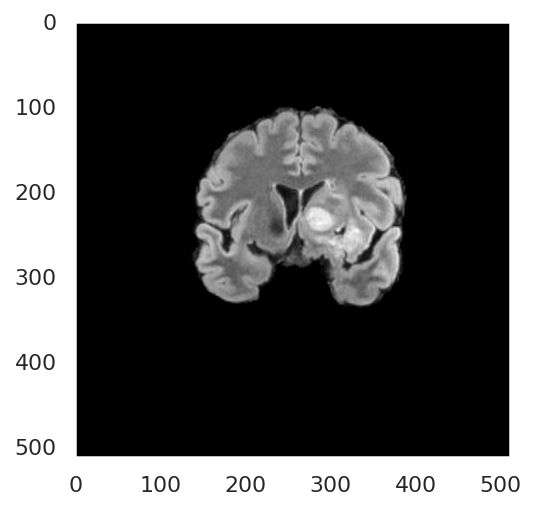

In [50]:
# plot one image
plt.imshow(test_meta.pixel_array, cmap='gray')
plt.grid(False)

In [64]:
# plot image of each MRI type
patient = '00000'
test_path = os.path.join(data_prefix, num)
print(len(os.listdir(data_prefix)))



585


## <a id='references'></a>
### References
[1]<a id='1'></a> https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/overview  
[2]<a id='2'></a> U.Baid, et al., “The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification”, arXiv:2107.02314, 2021.  
